Exploring the labels of the wildlife dataset

In [47]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import repackage

import tqdm
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from experiment_utils import set_env, seed_everything
set_env()
from cgn_extensions.mnists.dataloaders import get_dataloaders

from cgn_framework.mnists.generate_data import generate_cf_dataset, generate_dataset 

## Load datset

In [63]:
dl_train, dl_test = get_dataloaders('wildlife_MNIST', batch_size=1000, workers=8)

/Users/alexiscarras/opt/anaconda3/envs/cgn-cpu/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/Users/alexiscarras/opt/anaconda3/envs/cgn-cpu/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [64]:
print(f"Train: {dl_train.dataset.labels.shape[0]}")
print(f"Test: {dl_test.dataset.labels.shape[0]}")

Train: 10000
Test: 10000


In [65]:
random_idx = np.random.randint(0, dl_train.dataset.labels.shape[0])
#idx = 0

In [66]:
smpl_img = dl_train.dataset.__getitem__(random_idx)['ims']
smpl_label = dl_train.dataset.__getitem__(random_idx)['labels']
smpl_bbg = dl_train.dataset.__getitem__(random_idx)['back_text']
smpl_obg = dl_train.dataset.__getitem__(random_idx)['obj_text']

In [67]:
dl_train.dataset.__getitem__(random_idx).keys()

dict_keys(['ims', 'labels', 'back_text', 'obj_text'])

In [68]:
smpl_img.shape

torch.Size([3, 32, 32])

In [69]:
invTrans = transforms.Compose([
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


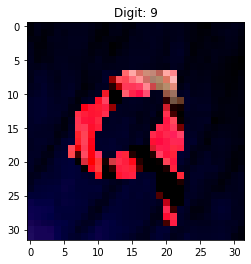

In [70]:
plt.imshow(invTrans(smpl_img).transpose(0,1).transpose(1,2))
label = smpl_label
plt.title(f"Digit: {label}")
plt.show()
#print(f"Background texture: {(smpl_bbg*255).tolist()}")
#print(f"Object color: {(smpl_obg*255).tolist()}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


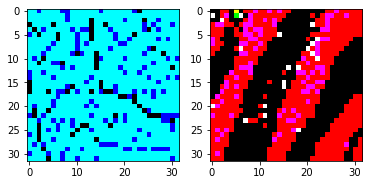

In [71]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(smpl_bbg.transpose(0,1).transpose(1,2)*255)
axs[1].imshow(smpl_obg.transpose(0,1).transpose(1,2)*255)

## Train backrgound texture CF

### ToDo: 
- map background and object texts to one of the 0-9 classes (probably upon the genereation of the dataset? depending on the file from which they are taken)
- search to find what different attributes the different backrounds differ in (if any)
- run training
- implement and run testing

In [108]:
from cgn_extensions.mnists.models.mnist_wildlife_cf import MNIST_WILDLIFE_BGTXT, train

In [109]:
# Args for training
args = argparse.Namespace()
args.batch_size = 512
args.gamma = 0.7
args.epochs = 10
args.lr = 0.01
args.log_interval = 10
args.dataset = 'wildlife_MNIST'

In [110]:
dl_train, dl_test = get_dataloaders(args.dataset, batch_size=args.batch_size, workers=4)

In [111]:
bg_model = MNIST_WILDLIFE_BGTXT(num_classes=10)

optimizer = optim.Adadelta(bg_model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)  # decays lr by gamma every step_size epochs

# push to device and train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = bg_model.to(device)
device

device(type='cpu')

In [112]:
train_accs = dict()
test_accs = dict()

for epoch in range(1, args.epochs+1):
    train_acc = train(args, bg_model, device, dl_train, optimizer, epoch, 'shape', max_batches=200)
    train_accs[epoch], loss = train_acc
    scheduler.step()
    

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x60 and 120x10)

In [ ]:
# Plot accuracies
fig, axs = plt.subplots(1,2)
axs[0].plot(train_accs.keys(), train_accs.values())
axs[0].set_ylabel('Accuracy')
#axs[1].plot(test_accs.keys(), test_accs.values())
#axs[1].set_ylabel('Log-Likelihood loss)
axs.set_xlabel('Epochs')
axs.legend(['train', 'test'])
plt.show()

In [ ]:
# simg = dl_train.dataset.__getitem__(0)['ims']
# slbl = dl_train.dataset.__getitem__(0)['labels']
# bg_text = dl_train.dataset.__getitem__(0)['bg_text']
# obj_text = dl_train.dataset.__getitem__(0)['obj_text']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


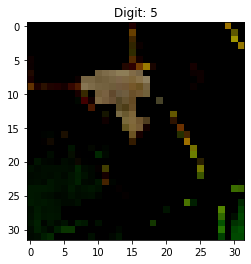

In [ ]:
# plt.imshow(simg.numpy().transpose(1,2,0))
# plt.title(f"Digit: {slbl}")
# plt.show()